# WatsonX Basic Multi-agent Collaboration

A single agent can usually operate effectively using a handful of tools within a single domain,

One way to approach complicated tasks is through a "divide-and-conquer" approach: create an specialized agent for each task or domain and route tasks to the correct "expert".

This notebook (inspired by the paper [AutoGen: Enabling Next-Gen LLM Applications via Multi-Agent Conversation](https://arxiv.org/abs/2308.08155), by Wu, et. al.) shows one way to do this using LangGraph.

The resulting graph will look something like the following diagram:

![multi_agent diagram](./img/simple_multi_agent_diagram.png)

Before we get started, a quick note: this and other multi-agent notebooks are designed to show _how_ you can implement certain design patterns in LangGraph. If the pattern suits your needs, we recommend combining it with some of the other fundamental patterns described elsewhere in the docs for best performance.

In [1]:
#%%capture --no-stderr
#%pip install -U langchain langchain_openai langsmith pandas langchain_experimental matplotlib langgraph langchain_core

In [2]:
import getpass
import os


def _set_if_undefined(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"Please provide your {var}")


_set_if_undefined("OPENAI_API_KEY")
_set_if_undefined("LANGCHAIN_API_KEY")
_set_if_undefined("TAVILY_API_KEY")

# Optional, add tracing in LangSmith
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_PROJECT"] = "Multi-agent Collaboration"

## Create Agents

The following helper functions will help create agents. These agents will then be nodes in the graph.

You can skip ahead if you just want to see what the graph looks like.

In [124]:
from langchain_core.messages import (
    BaseMessage,
    ToolMessage,
    HumanMessage,
)
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langgraph.graph import END, StateGraph


def create_agent(llm, tools, system_message: str , params_dict):
    """Create an agent."""
    parameters = params_dict["parameters"]
    model_id = params_dict["model_id"]
    url = params_dict["url"]
    api_key = params_dict["api_key"]
    project_id= params_dict["project_id"]
    prompt = ChatPromptTemplate.from_messages(
        [
            (
                "system",
                "You are a helpful AI assistant, collaborating with other assistants."
                " Use the provided tools to progress towards answering the question."
                " If you are unable to fully answer, that's OK, another assistant with different tools "
                " will help where you left off. Execute what you can to make progress."
                " If you or any of the other assistants have the final answer or deliverable,"
                " prefix your response with FINAL ANSWER so the team knows to stop."
                " You have access to the following tools: {tool_names}.\n{system_message}",
            ),
            MessagesPlaceholder(variable_name="messages"),
        ]
    )
    prompt = prompt.partial(system_message=system_message)
    prompt = prompt.partial(tool_names=", ".join([tool.name for tool in tools]))
    llm_with_tools = llm.bind_tools(tools=tools,model_id=model_id,url=url,apikey=api_key,project_id=project_id,params=parameters) 
    return prompt | llm_with_tools

## Define tools

We will also define some tools that our agents will use in the future

In [4]:
from langchain_core.tools import tool
from typing import Annotated
from langchain_experimental.utilities import PythonREPL
from langchain_community.tools.tavily_search import TavilySearchResults

tavily_tool = TavilySearchResults(max_results=5)

# Warning: This executes code locally, which can be unsafe when not sandboxed

repl = PythonREPL()


@tool
def python_repl(
    code: Annotated[str, "The python code to execute to generate your chart."]
):
    """Use this to execute python code. If you want to see the output of a value,
    you should print it out with `print(...)`. This is visible to the user."""
    try:
        result = repl.run(code)
    except BaseException as e:
        return f"Failed to execute. Error: {repr(e)}"
    result_str = f"Successfully executed:\n```python\n{code}\n```\nStdout: {result}"
    return (
        result_str + "\n\nIf you have completed all tasks, respond with FINAL ANSWER."
    )

## Create graph

Now that we've defined our tools and made some helper functions, will create the individual agents below and tell them how to talk to each other using LangGraph.

### Define State

We first define the state of the graph. This will just a list of messages, along with a key to track the most recent sender

In [5]:
import operator
from typing import Annotated, Sequence, TypedDict

from langchain_openai import ChatOpenAI
from typing_extensions import TypedDict


# This defines the object that is passed between each node
# in the graph. We will create different nodes for each agent and tool
class AgentState(TypedDict):
    messages: Annotated[Sequence[BaseMessage], operator.add]
    sender: str

In [6]:
#### Wrapper Version 0.1 Extended

import logging
from typing import Any, Dict, List, Optional, Sequence, Type, Union, Callable, Literal
from pydantic import BaseModel, Field
from langchain_core.tools import BaseTool
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.runnables import Runnable
from langchain_ibm import WatsonxLLM as BaseWatsonxLLM
from langchain_core.utils.function_calling import convert_to_openai_tool
from langchain_core.outputs import LLMResult, Generation, GenerationChunk
from langchain_core.messages import BaseMessage
from langchain_core.language_models import LanguageModelInput

logger = logging.getLogger(__name__)

class WatsonxLLM(BaseWatsonxLLM):
    """Extended IBM watsonx.ai large language models."""

    bound_tools: Optional[List[BaseTool]] = Field(default=None, exclude=True)

    def __init__(self, *args, tools: Optional[List[BaseTool]] = None, **kwargs):
        super().__init__(*args, **kwargs)
        self.bound_tools = tools or []

    def _generate(
        self,
        prompts: List[str],
        stop: Optional[List[str]] = None,
        run_manager: Optional[Any] = None,
        stream: Optional[bool] = None,
        **kwargs: Any,
        
    ) -> LLMResult:
        """Call the IBM watsonx.ai inference endpoint which then generate the response.
        Args:
            prompts: List of strings (prompts) to pass into the model.
            stop: Optional list of stop words to use when generating.
            run_manager: Optional callback manager.
            stream: Optional boolean flag to indicate streaming generation.
        Returns:
            The full LLMResult output.
        """
        params = self._get_chat_params(stop=stop)
        should_stream = stream if stream is not None else self.streaming
        if should_stream:
            if len(prompts) > 1:
                raise ValueError(
                    f"WatsonxLLM currently only supports single prompt, got {prompts}"
                )
            generation = GenerationChunk(text="")
            stream_iter = self._stream(
                prompts[0], stop=stop, run_manager=run_manager, **kwargs
            )
            for chunk in stream_iter:
                if generation is None:
                    generation = chunk
                else:
                    generation += chunk
            assert generation is not None
            if isinstance(generation.generation_info, dict):
                llm_output = generation.generation_info.pop("llm_output")
                return LLMResult(generations=[[generation]], llm_output=llm_output)
            return LLMResult(generations=[[generation]])
        else:
            # Apply tools before generation
            if self.bound_tools:
                print("# Apply tools before generation")
                print("self.bound_tools",self.bound_tools)
                print("prompts[0]",prompts[0])
                tool_output = self._evaluate_tools(self.bound_tools, prompts[0])
                print("Tool output: %s", tool_output)
                logger.info("Tool output: %s", tool_output)
                # You can include the tool output in the prompt or handle it as needed
                # For simplicity, we concatenate it to the prompt here
                #prompts[0] += "\n\n" + tool_output
                # Create a system prompt using the tool output
                system_prompt = (
                    f"You are an assistant with a tool. "
                    f"Provide a detailed answer to the user's query.\n\n"
                    f"User Query: {prompts[0]}\n\n"
                    f"Using the information below:\n"
                    f"Tool Results: {tool_output}\n\n"
                )
                # Set the new prompt with the system prompt first
                prompts[0] = system_prompt
            print("prompts",prompts)

            response = self.watsonx_model.generate(
                prompt=prompts, params=params, **kwargs
            )
            return self._create_llm_result(response)

    def _evaluate_tools(self, tool_instances: List[BaseTool], input_text: str) -> str:
        """Evaluate the provided tools and return their combined output.
        Args:
            tool_instances: List of tools to evaluate.
            input_text: Input text to provide to the tools.
        Returns:
            Combined output of the tool evaluations.
        """
        print("At _evaluate_tools:")
        
        print("tool_instances",tool_instances)
        print("input_text",input_text)
        test=tool_instances[0].invoke(input_text)
        print("test tool_instances[0].invoke:",test)
        combined_output = []
        for tool in tool_instances:
            result = tool.invoke(input_text)           
            print("Tool Results in _evaluate_tools:",result)
            #content = "\n\n".join([f"Content: {item['content']}" for item in result])
            content="Testing Results"
            ##content = "\n\n".join([f"Content: {item}" for item in result])

            #content= "WebSearch Results: " + " ".join(result['content'] for result in result)
            combined_output.append(content)
        return "\n\n".join(combined_output)

    @classmethod
    def bind_tools(
        cls,
        tools: Sequence[Union[Dict[str, Any], Type[BaseModel], Callable, BaseTool]],
        *,
        tool_choice: Optional[Union[Dict[str, str], Literal["any", "auto"], str]] = None,
        **kwargs: Any,
    ) -> 'WatsonxLLM':
        """Bind tool-like objects to this chat model.
        Assumes model is compatible with OpenAI tool-calling API.
        Args:
            tools: A list of tool definitions to bind to this chat model.
                Can be a dictionary, pydantic model, callable, or BaseTool. Pydantic
                models, callables, and BaseTools will be automatically converted to
                their schema dictionary representation.
            tool_choice: Which tool to require to call.
                Options are:
                    name of the tool (str): calls corresponding tool;
                    "auto" or None: automatically selects a tool (including no tool);
                    "any": force at least one tool to be called;
                    or a dict of the form:
                        {"type": "tool", "name": "tool_name"},
                        or {"type": "any"},
                        or {"type": "auto"};
            **kwargs: Any additional parameters to pass to the
                :class:`~langchain.runnable.Runnable` constructor.
        """
        formatted_tools = [convert_to_openai_tool(tool)["function"] for tool in tools]
        instance = cls(**kwargs)
        instance.bound_tools = tools
        if tool_choice is not None:
            kwargs["tool_choice"] = tool_choice
        return instance

    def _create_llm_result(self, response: List[dict]) -> LLMResult:
        """Create the LLMResult from the choices and prompts."""
        generations = []
        for res in response:
            results = res.get("results")
            if results:
                finish_reason = results[0].get("stop_reason")
                gen = Generation(
                    text=results[0].get("generated_text"),
                    generation_info={"finish_reason": finish_reason},
                )
                generations.append([gen])
        final_token_usage = self._extract_token_usage(response)
        llm_output = {
            "token_usage": final_token_usage,
            "model_id": self.model_id,
            "deployment_id": self.deployment_id,
        }
        return LLMResult(generations=generations, llm_output=llm_output)


prompts ['How is the weather in Genova']


'The weather in Genova is influenced by the Mediterranean Sea. It is mild and wet in winter and hot and dry in summer. There are no extreme weather conditions. The average temperature in Genova is 18.5°C. Genova is the capital of the Liguria region and the sixth-largest city in Italy. It is located on the Mediterranean coast, between the rivers Po and Arno, at the mouth of the River Lemene. Genova is a port city and its economy is based on shipbuilding, ship repair, and tourism. '

In [81]:
#### Wrapper Version 0.2 Extended
logger = logging.getLogger(__name__)

class WatsonxLLM(BaseWatsonxLLM):
    """Extended IBM watsonx.ai large language models."""

    bound_tools: Optional[List[BaseTool]] = Field(default=None, exclude=True)

    def __init__(self, *args, tools: Optional[List[BaseTool]] = None, **kwargs):
        super().__init__(*args, **kwargs)
        self.bound_tools = tools or []

    def _generate(
        self,
        prompts: List[str],
        stop: Optional[List[str]] = None,
        run_manager: Optional[Any] = None,
        stream: Optional[bool] = None,
        **kwargs: Any,
        
    ) -> LLMResult:
        """Call the IBM watsonx.ai inference endpoint which then generate the response.
        Args:
            prompts: List of strings (prompts) to pass into the model.
            stop: Optional list of stop words to use when generating.
            run_manager: Optional callback manager.
            stream: Optional boolean flag to indicate streaming generation.
        Returns:
            The full LLMResult output.
        """
        params = self._get_chat_params(stop=stop)
        should_stream = stream if stream is not None else self.streaming
        if should_stream:
            if len(prompts) > 1:
                raise ValueError(
                    f"WatsonxLLM currently only supports single prompt, got {prompts}"
                )
            generation = GenerationChunk(text="")
            stream_iter = self._stream(
                prompts[0], stop=stop, run_manager=run_manager, **kwargs
            )
            for chunk in stream_iter:
                if generation is None:
                    generation = chunk
                else:
                    generation += chunk
            assert generation is not None
            if isinstance(generation.generation_info, dict):
                llm_output = generation.generation_info.pop("llm_output")
                return LLMResult(generations=[[generation]], llm_output=llm_output)
            return LLMResult(generations=[[generation]])
        else:
            # Apply tools before generation
            if self.bound_tools:
                print("# Apply tools before generation")
                print("self.bound_tools", self.bound_tools)
                print("prompts[0]", prompts[0])
                tool_output = self._evaluate_tools(self.bound_tools, prompts[0])
                print("Tool output: %s", tool_output)
                logger.info("Tool output: %s", tool_output)
                # You can include the tool output in the prompt or handle it as needed
                # For simplicity, we concatenate it to the prompt here
                # prompts[0] += "\n\n" + tool_output
                # Create a system prompt using the tool output
                system_prompt = (
                    f"You are an assistant with a tool. "
                    f"Provide a detailed answer to the user's query.\n\n"
                    f"User Query: {prompts[0]}\n\n"
                    f"Using the information below:\n"
                    f"Tool Results: {tool_output}\n\n"
                )
                # Set the new prompt with the system prompt first
                prompts[0] = system_prompt
            print("prompts", prompts)

            response = self.watsonx_model.generate(
                prompt=prompts, params=params, **kwargs
            )
            return self._create_llm_result(response)

    def _evaluate_tools(self, tool_instances: List[BaseTool], input_text: str) -> str:
        """Evaluate the provided tools and return their combined output.
        Args:
            tool_instances: List of tools to evaluate.
            input_text: Input text to provide to the tools.
        Returns:
            Combined output of the tool evaluations.
        """
        print("At _evaluate_tools:")
        
        print("tool_instances", tool_instances)
        print("input_text", input_text)
        combined_output = []
        for tool in tool_instances:
            try:
                result = tool.invoke(input_text)
                print("Tool Results in _evaluate_tools:", result)
                combined_output.append(result)
            except Exception as e:
                print(f"Error invoking tool {tool.name}: {str(e)}")
        return "\n\n".join(combined_output)
    



    @classmethod
    def bind_tools(
        cls,
        tools: Sequence[Union[Dict[str, Any], Type[BaseModel], Callable, BaseTool]],
        *,
        tool_choice: Optional[Union[Dict[str, str], Literal["any", "auto"], str]] = None,
        **kwargs: Any,
    ) -> 'WatsonxLLM':
        """Bind tool-like objects to this chat model.
        Assumes model is compatible with OpenAI tool-calling API.
        Args:
            tools: A list of tool definitions to bind to this chat model.
                Can be a dictionary, pydantic model, callable, or BaseTool. Pydantic
                models, callables, and BaseTools will be automatically converted to
                their schema dictionary representation.
            tool_choice: Which tool to require to call.
                Options are:
                    name of the tool (str): calls corresponding tool;
                    "auto" or None: automatically selects a tool (including no tool);
                    "any": force at least one tool to be called;
                    or a dict of the form:
                        {"type": "tool", "name": "tool_name"},
                        or {"type": "any"},
                        or {"type": "auto"};
            **kwargs: Any additional parameters to pass to the
                :class:`~langchain.runnable.Runnable` constructor.
        """
        formatted_tools = [convert_to_openai_tool(tool)["function"] for tool in tools]
        instance = cls(**kwargs)
        instance.bound_tools = tools
        if tool_choice is not None:
            kwargs["tool_choice"] = tool_choice
        return instance

    def _create_llm_result(self, response: List[dict]) -> LLMResult:
        """Create the LLMResult from the choices and prompts."""
        generations = []
        for res in response:
            results = res.get("results")
            if results:
                finish_reason = results[0].get("stop_reason")
                gen = Generation(
                    text=results[0].get("generated_text"),
                    generation_info={"finish_reason": finish_reason},
                )
                generations.append([gen])
        final_token_usage = self._extract_token_usage(response)
        llm_output = {
            "token_usage": final_token_usage,
            "model_id": self.model_id,
            "deployment_id": self.deployment_id,
        }
        return LLMResult(generations=generations, llm_output=llm_output)

In [138]:
## v4
import logging
from typing import Any, Dict, List, Optional, Sequence, Type, Union, Callable, Literal
from pydantic import BaseModel, Field
from langchain_core.tools import BaseTool
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.runnables import Runnable
from langchain_ibm import WatsonxLLM as BaseWatsonxLLM
from langchain_core.utils.function_calling import convert_to_openai_tool
from langchain_core.outputs import LLMResult, Generation, GenerationChunk
from langchain_core.messages import BaseMessage
from langchain_core.language_models import LanguageModelInput
import json
logger = logging.getLogger(__name__)

class WatsonxLLM(BaseWatsonxLLM):
    """Extended IBM watsonx.ai large language models."""

    bound_tools: Optional[List[BaseTool]] = Field(default=None, exclude=True)

    def __init__(self, *args, tools: Optional[List[BaseTool]] = None, **kwargs):
        super().__init__(*args, **kwargs)
        self.bound_tools = tools or []

    def _generate(
        self,
        prompts: List[str],
        stop: Optional[List[str]] = None,
        run_manager: Optional[Any] = None,
        stream: Optional[bool] = None,
        **kwargs: Any,
        
    ) -> LLMResult:
        """Call the IBM watsonx.ai inference endpoint which then generate the response.
        Args:
            prompts: List of strings (prompts) to pass into the model.
            stop: Optional list of stop words to use when generating.
            run_manager: Optional callback manager.
            stream: Optional boolean flag to indicate streaming generation.
        Returns:
            The full LLMResult output.
        """
        params = self._get_chat_params(stop=stop)
        should_stream = stream if stream is not None else self.streaming
        if should_stream:
            if len(prompts) > 1:
                raise ValueError(
                    f"WatsonxLLM currently only supports single prompt, got {prompts}"
                )
            generation = GenerationChunk(text="")
            stream_iter = self._stream(
                prompts[0], stop=stop, run_manager=run_manager, **kwargs
            )
            for chunk in stream_iter:
                if generation is None:
                    generation = chunk
                else:
                    generation += chunk
            assert generation is not None
            if isinstance(generation.generation_info, dict):
                llm_output = generation.generation_info.pop("llm_output")
                return LLMResult(generations=[[generation]], llm_output=llm_output)
            return LLMResult(generations=[[generation]])
        else:
            # Apply tools before generation
            if self.bound_tools:
                tool_output = self._evaluate_tools(self.bound_tools, prompts[0])
                logger.info("Tool output: %s", tool_output)
                # Include the tool output in the prompt
                system_prompt = (
                    f"You are an assistant with a tool. "
                    f"Provide a detailed answer to the user's query.\n\n"
                    f"User Query: {prompts[0]}\n\n"
                    f"Using the information below:\n"
                    f"Tool Results: {tool_output}\n\n"
                )
                prompts[0] = system_prompt

            response = self.watsonx_model.generate(
                prompt=prompts, params=params, **kwargs
            )
            return self._create_llm_result(response)

    def _evaluate_tools(self, tool_instances: List[BaseTool], input_text: str) -> str:
        """Evaluate the provided tools and return their combined output.
        Args:
            tool_instances: List of tools to evaluate.
            input_text: Input text to provide to the tools.
        Returns:
            Combined output of the tool evaluations.
        """
        combined_output = []
        for tool in tool_instances:
            try:
                result = tool.invoke(input_text)
                if isinstance(result, dict):
                    result = json.dumps(result, indent=2)  # Convert dict to formatted string
                elif isinstance(result, list):
                    result = "\n".join([json.dumps(item, indent=2) if isinstance(item, dict) else str(item) for item in result])  # Convert list to string
                combined_output.append(result)
            except Exception as e:
                logger.error(f"Error invoking tool {tool.name}: {str(e)}")
        return "\n\n".join(combined_output)

    @classmethod
    def bind_tools(
        cls,
        tools: Sequence[Union[Dict[str, Any], Type[BaseModel], Callable, BaseTool]],
        *,
        tool_choice: Optional[Union[Dict[str, str], Literal["any", "auto"], str]] = None,
        **kwargs: Any,
    ) -> 'WatsonxLLM':
        """Bind tool-like objects to this chat model.
        Assumes model is compatible with OpenAI tool-calling API.
        Args:
            tools: A list of tool definitions to bind to this chat model.
                Can be a dictionary, pydantic model, callable, or BaseTool. Pydantic
                models, callables, and BaseTools will be automatically converted to
                their schema dictionary representation.
            tool_choice: Which tool to require to call.
                Options are:
                    name of the tool (str): calls corresponding tool;
                    "auto" or None: automatically selects a tool (including no tool);
                    "any": force at least one tool to be called;
                    or a dict of the form:
                        {"type": "tool", "name": "tool_name"},
                        or {"type": "any"},
                        or {"type": "auto"};
            **kwargs: Any additional parameters to pass to the
                :class:`~langchain.runnable.Runnable` constructor.
        """
        formatted_tools = [convert_to_openai_tool(tool)["function"] for tool in tools]
        instance = cls(**kwargs)
        instance.bound_tools = tools
        if tool_choice is not None:
            kwargs["tool_choice"] = tool_choice
        return instance

    def _create_llm_result(self, response: List[dict]) -> LLMResult:
        """Create the LLMResult from the choices and prompts."""
        generations = []
        for res in response:
            results = res.get("results")
            if results:
                finish_reason = results[0].get("stop_reason")
                gen = Generation(
                    text=results[0].get("generated_text"),
                    generation_info={"finish_reason": finish_reason},
                )
                generations.append([gen])
        final_token_usage = self._extract_token_usage(response)
        llm_output = {
            "token_usage": final_token_usage,
            "model_id": self.model_id,
            "deployment_id": self.deployment_id,
        }
        return LLMResult(generations=generations, llm_output=llm_output)


In [147]:
##v5
import logging
from typing import Any, Dict, List, Optional, Sequence, Type, Union, Callable, Literal
from pydantic import BaseModel, Field
from langchain_core.tools import BaseTool
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.runnables import Runnable
from langchain_ibm import WatsonxLLM as BaseWatsonxLLM
from langchain_core.utils.function_calling import convert_to_openai_tool
from langchain_core.outputs import LLMResult, Generation, GenerationChunk
from langchain_core.messages import BaseMessage
from langchain_core.language_models import LanguageModelInput
import json

logger = logging.getLogger(__name__)

class WatsonxLLM(BaseWatsonxLLM):
    """Extended IBM watsonx.ai large language models."""

    bound_tools: Optional[List[BaseTool]] = Field(default=None, exclude=True)

    def __init__(self, *args, tools: Optional[List[BaseTool]] = None, **kwargs):
        super().__init__(*args, **kwargs)
        self.bound_tools = tools or []

    def _generate(
        self,
        prompts: List[str],
        stop: Optional[List[str]] = None,
        run_manager: Optional[Any] = None,
        stream: Optional[bool] = None,
        **kwargs: Any,
    ) -> LLMResult:
        """Call the IBM watsonx.ai inference endpoint which then generate the response.
        Args:
            prompts: List of strings (prompts) to pass into the model.
            stop: Optional list of stop words to use when generating.
            run_manager: Optional callback manager.
            stream: Optional boolean flag to indicate streaming generation.
        Returns:
            The full LLMResult output.
        """
        params = self._get_chat_params(stop=stop)
        should_stream = stream if stream is not None else self.streaming
        if should_stream:
            if len(prompts) > 1:
                raise ValueError(
                    f"WatsonxLLM currently only supports single prompt, got {prompts}"
                )
            generation = GenerationChunk(text="")
            stream_iter = self._stream(
                prompts[0], stop=stop, run_manager=run_manager, **kwargs
            )
            for chunk in stream_iter:
                if generation is None:
                    generation = chunk
                else:
                    generation += chunk
            assert generation is not None
            if isinstance(generation.generation_info, dict):
                llm_output = generation.generation_info.pop("llm_output")
                return LLMResult(generations=[[generation]], llm_output=llm_output)
            return LLMResult(generations=[[generation]])
        else:
            # Apply tools before generation
            if self.bound_tools:
                tool_output = self._evaluate_tools(self.bound_tools, prompts[0])
                logger.info("Tool output: %s", tool_output)
                # Include the tool output in the prompt
                system_prompt = (
                    f"You are an assistant with a tool. "
                    f"Provide a detailed answer to the user's query.\n\n"
                    f"User Query: {prompts[0]}\n\n"
                    f"Using the information below:\n"
                    f"Tool Results: {tool_output}\n\n"
                )
                prompts[0] = system_prompt

            response = self.watsonx_model.generate(
                prompt=prompts, params=params, **kwargs
            )
            return self._create_llm_result(response)

    def _evaluate_tools(self, tool_instances: List[BaseTool], input_text: str) -> str:
        """Evaluate the provided tools and return their combined output.
        Args:
            tool_instances: List of tools to evaluate.
            input_text: Input text to provide to the tools.
        Returns:
            Combined output of the tool evaluations.
        """
        combined_output = []
        for tool in tool_instances:
            try:
                result = tool.invoke(input_text)
                if isinstance(result, dict):
                    result = json.dumps(result, indent=2)  # Convert dict to formatted string
                elif isinstance(result, list):
                    result = "\n".join([json.dumps(item, indent=2) if isinstance(item, dict) else str(item) for item in result])  # Convert list to string
                combined_output.append(result)
            except Exception as e:
                logger.error(f"Error invoking tool {tool.name}: {str(e)}")
        return "\n\n".join(combined_output)

    @classmethod
    def bind_tools(
        cls,
        tools: Sequence[Union[Dict[str, Any], Type[BaseModel], Callable, BaseTool]],
        *,
        tool_choice: Optional[Union[Dict[str, str], Literal["any", "auto"], str]] = None,
        **kwargs: Any,
    ) -> 'WatsonxLLM':
        """Bind tool-like objects to this chat model.
        Assumes model is compatible with OpenAI tool-calling API.
        Args:
            tools: A list of tool definitions to bind to this chat model.
                Can be a dictionary, pydantic model, callable, or BaseTool. Pydantic
                models, callables, and BaseTools will be automatically converted to
                their schema dictionary representation.
            tool_choice: Which tool to require to call.
                Options are:
                    name of the tool (str): calls corresponding tool;
                    "auto" or None: automatically selects a tool (including no tool);
                    "any": force at least one tool to be called;
                    or a dict of the form:
                        {"type": "tool", "name": "tool_name"},
                        or {"type": "any"},
                        or {"type": "auto"};
            **kwargs: Any additional parameters to pass to the
                :class:`~langchain.runnable.Runnable` constructor.
        """
        formatted_tools = [convert_to_openai_tool(tool)["function"] for tool in tools]
        instance = cls(**kwargs)
        instance.bound_tools = tools
        if tool_choice is not None:
            kwargs["tool_choice"] = tool_choice
        return instance

    def _create_llm_result(self, response: List[dict]) -> LLMResult:
        """Create the LLMResult from the choices and prompts."""
        generations = []
        for res in response:
            results = res.get("results")
            if results:
                finish_reason = results[0].get("stop_reason")
                gen = Generation(
                    text=results[0].get("generated_text"),
                    generation_info={"finish_reason": finish_reason},
                )
                generations.append([gen])
        final_token_usage = self._extract_token_usage(response)
        llm_output = {
            "token_usage": final_token_usage,
            "model_id": self.model_id,
            "deployment_id": self.deployment_id,
        }
        return LLMResult(generations=generations, llm_output=llm_output)


In [148]:
from dotenv import load_dotenv
from ibm_watsonx_ai.metanames import GenTextParamsMetaNames as GenParams
from ibm_watsonx_ai.foundation_models.utils.enums import DecodingMethods
import getpass
import os
load_dotenv()  # Load environment variables from .env file
def _set_env(var: str):
    load_dotenv()  # Load environment variables from .env file
    env_var = os.getenv(var)
    if not env_var:
        env_var = getpass.getpass(f"{var}: ")
        os.environ[var] = env_var
    return env_var

_set_env("TAVILY_API_KEY")
api_key = _set_env("WATSONX_API_KEY")
project_id = _set_env("PROJECT_ID")
url = "https://us-south.ml.cloud.ibm.com"
   
# Create an instance of WatsonxLLM
# WatsonxLLM initialization
parameters = {
    GenParams.DECODING_METHOD: DecodingMethods.SAMPLE.value,
    GenParams.MAX_NEW_TOKENS: 1000,
    GenParams.MIN_NEW_TOKENS: 50,
    GenParams.TEMPERATURE: 0.7,
    GenParams.TOP_K: 50,
    GenParams.TOP_P: 1
}
model_id = "ibm/granite-13b-instruct-v2"
watsonx_instance  = WatsonxLLM(
    model_id=model_id,
    url=url,
    apikey=api_key,
    project_id=project_id,
    params=parameters
)
watsonx_instance.invoke("How is the weather in Genova")    

'The weather in Genova is mild and rainy. The average temperature in Genova is between 10 and 20 degrees Celsius. The weather is influenced by the Mistral wind, which blows from the Alps to the Ligurian Sea. '

In [149]:
# Example usage:
tool = TavilySearchResults(max_results=4)
llm_with_tools = watsonx_instance.bind_tools(tools=[tool],model_id=model_id,url=url,apikey=api_key,project_id=project_id,params=parameters) 
llm_with_tools.invoke("Who is Ruslan Magana?")  

'Ruslan Magana Vsevolodovna is a Data Scientist, a Cloud Architect and a Physicist. He is specialized in Artificial Intelligence, with a distinct focus on Neural Networks. Ruslan Magana Vsevolodovna is the co-founder and CEO of GeometricVisions, an AI-driven company that provides solutions to the problems of the retail and e-commerce industry. Ruslan Magana Vsevolodovna is also the founder of the Artificial Intelligence Lab, a community of Data Scientists, developers and enthusiasts. Ruslan Magana Vsevolodovna is a member of the Forbes Technology Council. Ruslan Magana Vsevolodovna is a member of the Forbes Council. Ruslan Magana Vsevolodovna is a member of the Forbes Council. Ruslan Magana Vsevolodovna is a member of the Forbes Council. Ruslan Magana Vsevolodovna is a member of the Forbes Council. Ruslan Magana Vsevolodovna is a member of the Forbes Council. Ruslan Magana Vsevolodovna is a member of the Forbes Council. Ruslan Magana Vsevolodovna is a member of the Forbes Council. Rusl

# Apply tools before generation
self.bound_tools [TavilySearchResults(max_results=4)]
prompts[0] Who is Ruslan Magana?
At _evaluate_tools:
tool_instances [TavilySearchResults(max_results=4)]
input_text Who is Ruslan Magana?


Error invoking tool tavily_search_results_json: sequence item 0: expected str instance, dict found


Tool output: %s 
prompts ["You are an assistant with a tool. Provide a detailed answer to the user's query.\n\nUser Query: Who is Ruslan Magana?\n\nUsing the information below:\nTool Results: \n\n"]


' Ruslan Magana is a fictional character in the series "The Witcher" and the video games "The Witcher" and "The Witcher 3: Wild Hunt". In the games, he is a citizen of the Nilfgaardian Empire and a Witcher. He is a member of the guard of Kaer Morhen. His witcher sign is a Griffin.'

In [150]:
response = llm_with_tools._generate(prompts=["Who is Ruslan Magana?"])
print(response)

generations=[[Generation(text='Ruslan Magana Vsevolodovna is a Data Scientist, a Cloud Architect and a Physicist. His expertise is in Generative AI and prompt engineering. He has been mentioned in multiple places online, including ResearchGate, Google Scholar and his own website. He is also a National Institute for Nuclear Physics.', generation_info={'finish_reason': 'eos_token'})]] llm_output={'token_usage': {'generated_token_count': 68, 'input_token_count': 481}, 'model_id': 'ibm/granite-13b-instruct-v2', 'deployment_id': ''} run=None


In [132]:
# WatsonxLLM initialization patemeters
params_dict = {
    "parameters": parameters,
    "model_id": model_id,
    "url": url,
    "api_key": api_key,
    "project_id": project_id
}

In [87]:
os.environ["WATSONX_APIKEY"] =api_key

#v7

In [3]:
#v5
import logging
from typing import Any, Dict, List, Optional, Sequence, Type, Union, Callable, Literal
from pydantic import BaseModel, Field
from langchain_core.tools import BaseTool
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.runnables import Runnable
from langchain_ibm import WatsonxLLM as BaseWatsonxLLM
from langchain_core.utils.function_calling import convert_to_openai_tool
from langchain_core.outputs import LLMResult, Generation, GenerationChunk
from langchain_core.messages import BaseMessage
from langchain_core.language_models import LanguageModelInput
import json

In [18]:
#v5
import logging
from typing import Any, Dict, List, Optional, Sequence, Type, Union, Callable, Literal
from pydantic import BaseModel, Field
from langchain_core.tools import BaseTool
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.runnables import Runnable
from langchain_ibm import WatsonxLLM as BaseWatsonxLLM
from langchain_core.utils.function_calling import convert_to_openai_tool
from langchain_core.outputs import LLMResult, Generation, GenerationChunk
from langchain_core.messages import BaseMessage
from langchain_core.language_models import LanguageModelInput
import json

logger = logging.getLogger(__name__)

class WatsonxLLM(BaseWatsonxLLM):
    """Extended IBM watsonx.ai large language models."""

    bound_tools: Optional[List[BaseTool]] = Field(default=None, exclude=True)

    def __init__(self, *args, tools: Optional[List[BaseTool]] = None, **kwargs):
        super().__init__(*args, **kwargs)
        self.bound_tools = tools or []

    def _generate(
        self,
        prompts: List[str],
        stop: Optional[List[str]] = None,
        run_manager: Optional[Any] = None,
        stream: Optional[bool] = None,
        **kwargs: Any,
    ) -> LLMResult:
        """Call the IBM watsonx.ai inference endpoint which then generate the response.
        Args:
            prompts: List of strings (prompts) to pass into the model.
            stop: Optional list of stop words to use when generating.
            run_manager: Optional callback manager.
            stream: Optional boolean flag to indicate streaming generation.
        Returns:
            The full LLMResult output.
        """
        params = self._get_chat_params(stop=stop)
        should_stream = stream if stream is not None else self.streaming
        if should_stream:
            if len(prompts) > 1:
                raise ValueError(
                    f"WatsonxLLM currently only supports single prompt, got {prompts}"
                )
            generation = GenerationChunk(text="")
            stream_iter = self._stream(
                prompts[0], stop=stop, run_manager=run_manager, **kwargs
            )
            for chunk in stream_iter:
                if generation is None:
                    generation = chunk
                else:
                    generation += chunk
            assert generation is not None
            if isinstance(generation.generation_info, dict):
                llm_output = generation.generation_info.pop("llm_output")
                return LLMResult(generations=[[generation]], llm_output=llm_output)
            return LLMResult(generations=[[generation]])
        else:
            # Apply tools before generation
            if self.bound_tools:
                tool_output = self._evaluate_tools(self.bound_tools, prompts[0])
                logger.info("Tool output: %s", tool_output)
                # Include the tool output in the prompt
                system_prompt = (
                    f"You are an assistant with a tool. "
                    f"Provide a detailed answer to the user's query.\n\n"
                    f"User Query: {prompts[0]}\n\n"
                    f"Using the information below:\n"
                    f"Tool Results: {tool_output}\n\n"
                )
                prompts[0] = system_prompt

            response = self.watsonx_model.generate(
                prompt=prompts, params=params, **kwargs
            )
            return self._create_llm_result(response)

    def _evaluate_tools(self, tool_instances: List[BaseTool], input_text: str) -> str:
        """Evaluate the provided tools and return their combined output.
        Args:
            tool_instances: List of tools to evaluate.
            input_text: Input text to provide to the tools.
        Returns:
            Combined output of the tool evaluations.
        """
        combined_output = []
        for tool in tool_instances:
            try:
                result = tool.invoke(input_text)
                if isinstance(result, dict):
                    #isinstance 1
                    print("isinstance 1",result)
                    result = json.dumps(result, indent=2)  # Convert dict to formatted string
                elif isinstance(result, list):
                    #isinstance 2
                    print("isinstance 2",result)
                    result = "\n".join([json.dumps(item, indent=2) if isinstance(item, dict) else str(item) for item in result])  # Convert list to string
                combined_output.append(result)
            except Exception as e:
                logger.error(f"Error invoking tool {tool.name}: {str(e)}")
        return "\n\n".join(combined_output)

    @classmethod
    def bind_tools(
        cls,
        tools: Sequence[Union[Dict[str, Any], Type[BaseModel], Callable, BaseTool]],
        *,
        tool_choice: Optional[Union[Dict[str, str], Literal["any", "auto"], str]] = None,
        **kwargs: Any,
    ) -> 'WatsonxLLM':
        """Bind tool-like objects to this chat model.
        Assumes model is compatible with OpenAI tool-calling API.
        Args:
            tools: A list of tool definitions to bind to this chat model.
                Can be a dictionary, pydantic model, callable, or BaseTool. Pydantic
                models, callables, and BaseTools will be automatically converted to
                their schema dictionary representation.
            tool_choice: Which tool to require to call.
                Options are:
                    name of the tool (str): calls corresponding tool;
                    "auto" or None: automatically selects a tool (including no tool);
                    "any": force at least one tool to be called;
                    or a dict of the form:
                        {"type": "tool", "name": "tool_name"},
                        or {"type": "any"},
                        or {"type": "auto"};
            **kwargs: Any additional parameters to pass to the
                :class:`~langchain.runnable.Runnable` constructor.
        """
        formatted_tools = [convert_to_openai_tool(tool)["function"] for tool in tools]
        instance = cls(**kwargs)
        instance.bound_tools = tools
        if tool_choice is not None:
            kwargs["tool_choice"] = tool_choice
        return instance

    def _create_llm_result(self, response: List[dict]) -> LLMResult:
        """Create the LLMResult from the choices and prompts."""
        generations = []
        for res in response:
            results = res.get("results")
            if results:
                finish_reason = results[0].get("stop_reason")
                gen = Generation(
                    text=results[0].get("generated_text"),
                    generation_info={"finish_reason": finish_reason},
                )
                generations.append([gen])
        final_token_usage = self._extract_token_usage(response)
        llm_output = {
            "token_usage": final_token_usage,
            "model_id": self.model_id,
            "deployment_id": self.deployment_id,
        }
        return LLMResult(generations=generations, llm_output=llm_output)


In [19]:
# Example usage:
tool = TavilySearchResults(max_results=4)
llm_with_tools = watsonx_instance.bind_tools(tools=[tool],model_id=model_id,url=url,apikey=api_key,project_id=project_id,params=parameters) 
llm_with_tools.invoke("Who is Ruslan Magana?") 


'Ruslan Magana Vsevolodovna is a Data Scientist, a Cloud Architect and a Physicist. He focuses on Artificial Intelligence, with a distinct focus on Neural Networks. His expertise is Generative AI and prompt engineering. Ruslan Magana Vsevolodovna has written many publications.'

In [20]:
response = llm_with_tools._generate(prompts=["Who is Ruslan Magana?"])
print(response)

generations=[[Generation(text='Ruslan Magana Vsevolodovna is a Data Scientist, Cloud Architect and Physicist. Ruslan Magana Vsevolodovna is the CEO of Ruslan Magana Vsevolodovna consultancy firm. Ruslan Magana Vsevolodovna is also the founder of Ruslan Magana Vsevolodovna company. Ruslan Magana Vsevolodovna is based out of Italy and has worked with companies such as IBM and Google. Ruslan Magana Vsevolodovna is an expert in the field of Artificial Intelligence, with a focus on Neural Networks. Ruslan Magana Vsevolodovna is the author of the book "The Secrets of the World\'s Most Powerful Chip". Ruslan Magana Vsevolodovna is the winner of the IBM Watson AI XPRIZE. Ruslan Magana Vsevolodovna is the winner of the IBM Watson AI XPRIZE.', generation_info={'finish_reason': 'eos_token'})]] llm_output={'token_usage': {'generated_token_count': 207, 'input_token_count': 478}, 'model_id': 'ibm/granite-13b-instruct-v2', 'deployment_id': ''} run=None


In [21]:
from dotenv import load_dotenv
from ibm_watsonx_ai.metanames import GenTextParamsMetaNames as GenParams
from ibm_watsonx_ai.foundation_models.utils.enums import DecodingMethods
import getpass
import os
load_dotenv()  # Load environment variables from .env file
def _set_env(var: str):
    load_dotenv()  # Load environment variables from .env file
    env_var = os.getenv(var)
    if not env_var:
        env_var = getpass.getpass(f"{var}: ")
        os.environ[var] = env_var
    return env_var

_set_env("TAVILY_API_KEY")
api_key = _set_env("WATSONX_API_KEY")
project_id = _set_env("PROJECT_ID")
url = "https://us-south.ml.cloud.ibm.com"
   
# Create an instance of WatsonxLLM
# WatsonxLLM initialization
parameters = {
    GenParams.DECODING_METHOD: DecodingMethods.SAMPLE.value,
    GenParams.MAX_NEW_TOKENS: 1000,
    GenParams.MIN_NEW_TOKENS: 50,
    GenParams.TEMPERATURE: 0.7,
    GenParams.TOP_K: 50,
    GenParams.TOP_P: 1
}
model_id = "ibm/granite-13b-instruct-v2"
watsonx_instance  = WatsonxLLM(
    model_id=model_id,
    url=url,
    apikey=api_key,
    project_id=project_id,
    params=parameters
)
watsonx_instance.invoke("How is the weather in Genova")    

'The weather in Genova is mild, wet, and windy. The average temperature is 13.2°C (56.1°F), with an average high of 20.2°C (68.4°F) and an average low of 6.4°C (43.5°F).'

In [22]:
from langchain_core.messages import BaseMessage, ToolMessage, HumanMessage
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langgraph.graph import END, StateGraph
from langchain_community.tools.tavily_search import TavilySearchResults
from dotenv import load_dotenv
from ibm_watsonx_ai.metanames import GenTextParamsMetaNames as GenParams
from ibm_watsonx_ai.foundation_models.utils.enums import DecodingMethods
import getpass
import os
def create_agent(llm, tools, system_message: str, params_dict):
    """Create an agent."""
    parameters = params_dict["parameters"]
    model_id = params_dict["model_id"]
    url = params_dict["url"]
    api_key = params_dict["api_key"]
    project_id = params_dict["project_id"]

    prompt = ChatPromptTemplate.from_messages(
        [
            (
                "system",
                "You are a helpful AI assistant, collaborating with other assistants."
                " Use the provided tools to progress towards answering the question."
                " If you are unable to fully answer, that's OK, another assistant with different tools "
                " will help where you left off. Execute what you can to make progress."
                " If you or any of the other assistants have the final answer or deliverable,"
                " prefix your response with FINAL ANSWER so the team knows to stop."
                " You have access to the following tools: {tool_names}.\n{system_message}",
            ),
            MessagesPlaceholder(variable_name="messages"),
        ]
    )

    prompt = prompt.partial(system_message=system_message)
    prompt = prompt.partial(tool_names=", ".join([tool.name for tool in tools]))

    llm_with_tools = llm.bind_tools(
        tools=tools,
        model_id=model_id,
        url=url,
        apikey=api_key,
        project_id=project_id,
        params=parameters
    )

    return prompt | llm_with_tools

# Example usage
params_dict = {
    "parameters": parameters,
    "model_id": model_id,
    "url": url,
    "api_key": api_key,
    "project_id": project_id
}

tavily_tool = TavilySearchResults(max_results=4)

research_agent = create_agent(
    watsonx_instance,
    [tavily_tool],
    system_message="You should provide accurate data for the chart_generator to use.",
    params_dict=params_dict,
)

# Invoke the agent
response = research_agent.invoke(["Who is Ruslan Magana?"])
print(response)


Final answer: Sorry, I was unable to find any information on Ruslan Magana.

I found this article on him, but it's in Russian. If you'd like, I can translate it for you.

FINAL ANSWER: Ruslan Magana (footballer)




In [16]:
import logging
from dotenv import load_dotenv
from typing import List
from ibm_watsonx_ai.metanames import GenTextParamsMetaNames as GenParams
from ibm_watsonx_ai.foundation_models.utils.enums import DecodingMethods
import getpass
import os
from langchain_core.tools import BaseTool
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain_core.messages import BaseMessage, ToolMessage, HumanMessage
from langgraph.graph import END, StateGraph
from langchain_ibm import WatsonxLLM as BaseWatsonxLLM
# Load environment variables from .env file
load_dotenv()

def _set_env(var: str) -> str:
    load_dotenv()
    env_var = os.getenv(var)
    if not env_var:
        env_var = getpass.getpass(f"{var}: ")
        os.environ[var] = env_var
    return env_var

def create_agent(llm: WatsonxLLM, tools: List[BaseTool], system_message: str, params_dict):
    """Create an agent."""
    parameters = params_dict["parameters"]
    model_id = params_dict["model_id"]
    url = params_dict["url"]
    api_key = params_dict["api_key"]
    project_id = params_dict["project_id"]
    prompt = ChatPromptTemplate.from_messages(
        [
            (
                "system",
                "You are a helpful AI assistant, collaborating with other assistants."
                " Use the provided tools to progress towards answering the question."
                " If you are unable to fully answer, that's OK, another assistant with different tools "
                " will help where you left off. Execute what you can to make progress."
                " If you or any of the other assistants have the final answer or deliverable,"
                " prefix your response with FINAL ANSWER so the team knows to stop."
                " You have access to the following tools: {tool_names}.\n{system_message}",
            ),
            MessagesPlaceholder(variable_name="messages"),
        ]
    )
    prompt = prompt.partial(system_message=system_message)
    prompt = prompt.partial(tool_names=", ".join([tool.name for tool in tools]))

    llm_with_tools = llm.bind_tools(
        tools=tools,
        model_id=model_id,
        url=url,
        apikey=api_key,
        project_id=project_id,
        params=parameters
    )

    return prompt | llm_with_tools

# Set up environment variables
_set_env("TAVILY_API_KEY")

api_key = _set_env("WATSONX_API_KEY")
project_id = _set_env("PROJECT_ID")
url = "https://us-south.ml.cloud.ibm.com"


# WatsonxLLM initialization parameters
parameters = {
    GenParams.DECODING_METHOD: DecodingMethods.SAMPLE.value,
    GenParams.MAX_NEW_TOKENS: 1000,
    GenParams.MIN_NEW_TOKENS: 50,
    GenParams.TEMPERATURE: 0.7,
    GenParams.TOP_K: 50,
    GenParams.TOP_P: 1
}
model_id = "ibm/granite-13b-instruct-v2"

# Create an instance of WatsonxLLM
watsonx_instance = WatsonxLLM(
    model_id=model_id,
    url=url,
    apikey=api_key,
    project_id=project_id,
    params=parameters
)
# Example usage
params_dict = {
    "parameters": parameters,
    "model_id": model_id,
    "url": url,
    "api_key": api_key,
    "project_id": project_id
}
# Create the tools
tavily_tool = TavilySearchResults(max_results=4)

# Create the agent
system_message = "Assist with research questions using available tools."
research_agent = create_agent(
    watsonx_instance,
    [tavily_tool],
    system_message,
    params_dict=params_dict,
)

# Example usage: Invoke the agent
response = research_agent.invoke(["Who is Ruslan Magana?"])
print(response)


FINAL ANSWER

Ruslan Magana (russian: Руслан Магана́, born 26 January 1983 in Moscow) is a Russian football player who last played for FC Oryol.

Ruslan Magana is a Russian football player, who played for FC Oryol.



#v7


In [ ]:
import logging
from typing import Any, Dict, List, Optional, Sequence, Type, Union, Literal
from pydantic import BaseModel, Field
from langchain_core.tools import BaseTool
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.runnables import Runnable
from langchain_ibm import WatsonxLLM as BaseWatsonxLLM
from langchain_core.utils.function_calling import convert_to_openai_tool
from langchain_core.outputs import LLMResult, Generation, GenerationChunk
from langchain_core.messages import BaseMessage
from langchain_core.language_models import LanguageModelInput
import json

logger = logging.getLogger(__name__)

class WatsonxLLM(BaseWatsonxLLM):
    """Extended IBM watsonx.ai large language models."""

    bound_tools: Optional[List[BaseTool]] = Field(default=None, exclude=True)

    def __init__(self, *args, tools: Optional[List[BaseTool]] = None, **kwargs):
        super().__init__(*args, **kwargs)
        self.bound_tools = tools or []

    def _generate(
        self,
        prompts: List[str],
        stop: Optional[List[str]] = None,
        run_manager: Optional[Any] = None,
        stream: Optional[bool] = None,
        **kwargs: Any,
    ) -> LLMResult:
        """Call the IBM watsonx.ai inference endpoint which then generates the response."""
        params = self._get_chat_params(stop=stop)
        should_stream = stream if stream is not None else self.streaming
        if should_stream:
            if len(prompts) > 1:
                raise ValueError(
                    f"WatsonxLLM currently only supports single prompt, got {prompts}"
                )
            generation = GenerationChunk(text="")
            stream_iter = self._stream(
                prompts[0], stop=stop, run_manager=run_manager, **kwargs
            )
            for chunk in stream_iter:
                if generation is None:
                    generation = chunk
                else:
                    generation += chunk
            assert generation is not None
            if isinstance(generation.generation_info, dict):
                llm_output = generation.generation_info.pop("llm_output")
                return LLMResult(generations=[[generation]], llm_output=llm_output)
            return LLMResult(generations=[[generation]])
        else:
            # Apply tools before generation
            if self.bound_tools:
                tool_output = self._evaluate_tools(self.bound_tools, prompts[0])
                print("Tool output: %s", tool_output)
                # Include the tool output in the prompt
                system_prompt = (
                    f"You are an assistant with a tool. "
                    f"Provide a detailed answer to the user's query.\n\n"
                    f"User Query: {prompts[0]}\n\n"
                    f"Using the information below:\n"
                    f"Tool Results: {tool_output}\n\n"
                )
                prompts[0] = system_prompt

            response = self.watsonx_model.generate(
                prompt=prompts, params=params, **kwargs
            )
            return self._create_llm_result(response)

    def _evaluate_tools(self, tool_instances: List[BaseTool], input_text: str) -> str:
        """Evaluate the provided tools and return their combined output."""
        combined_output = []
        for tool in tool_instances:
            try:
                result = tool.invoke(input_text)
                if isinstance(result, dict):
                    result = json.dumps(result, indent=2)  # Convert dict to formatted string
                elif isinstance(result, list):
                    result = "\n".join([json.dumps(item, indent=2) if isinstance(item, dict) else str(item) for item in result])  # Convert list to string
                combined_output.append(result)
            except Exception as e:
                print(f"Error invoking tool {tool.name}: {str(e)}")
                #logger.error(f"Error invoking tool {tool.name}: {str(e)}")
        return "\n\n".join(combined_output)

    @classmethod
    def bind_tools(
        cls,
        tools: Sequence[Union[Dict[str, Any], Type[BaseModel], Callable, BaseTool]],
        *,
        tool_choice: Optional[Union[Dict[str, str], Literal["any", "auto"], str]] = None,
        **kwargs: Any,
    ) -> 'WatsonxLLM':
        """Bind tool-like objects to this chat model."""
        formatted_tools = [convert_to_openai_tool(tool)["function"] for tool in tools]
        instance = cls(**kwargs)
        instance.bound_tools = tools
        if tool_choice is not None:
            kwargs["tool_choice"] = tool_choice
        return instance

    def _create_llm_result(self, response: List[dict]) -> LLMResult:
        """Create the LLMResult from the choices and prompts."""
        generations = []
        for res in response:
            results = res.get("results")
            if results:
                finish_reason = results[0].get("stop_reason")
                gen = Generation(
                    text=results[0].get("generated_text"),
                    generation_info={"finish_reason": finish_reason},
                )
                generations.append([gen])
        final_token_usage = self._extract_token_usage(response)
        llm_output = {
            "token_usage": final_token_usage,
            "model_id": self.model_id,
            "deployment_id": self.deployment_id,
        }
        return LLMResult(generations=generations, llm_output=llm_output)


In [30]:
# Example usage:
tool = TavilySearchResults(max_results=4)
llm_with_tools = watsonx_instance.bind_tools(tools=[tool],model_id=model_id,url=url,apikey=api_key,project_id=project_id,params=parameters) 
llm_with_tools.invoke("Who is Ruslan Magana?") 

isinstance 2 [{'url': 'https://ruslanmv.com/about', 'content': "I'm Ruslan Magana Vsevolodovna. I'm a Data Scientist, a Cloud Architect and a Physicist. About me. I am Data Scientist specializing in Artificial Intelligence, with a distinct focus on Neural Networks. My core expertise lies in Generative AI and prompt engineering. I possess a strong commitment to precision and boast an extensive track ..."}, {'url': 'https://www.researchgate.net/profile/Ruslan-Magana-Vsevolodovna', 'content': 'Nov 2020. Ruslan Magaña Vsevolodovna. The structure of odd-A Rh115,117 and Pd115,117 isotopes is studied by means of the neutron-proton interacting boson-fermion model (IBFM-2). JP=12+ quantum ...'}, {'url': 'https://scholar.google.com/citations?user=rWBrOpwAAAAJ', 'content': 'Ruslan Magana Vsevolodovna. National Institute for Nuclear Physics. Verified email at ge.infn.it - Homepage. ... R Magana, H Zheng, A Bonasera. International Journal of Modern Physics E 21 (01), 1250006, 2012. 4: 2012: Transfe

'Ruslan Magana Vsevolodovna is a Data Scientist, Cloud Architect and Physicist. His expertise lies in Generative AI and prompt engineering. He also has research interests in Nuclear Physics. He has publications on Transfer reactions between odd-odd and even-even nuclei by using the interacting boson fermion model and 0 $\\sim$ $\\boxed{2}$ $\\sim$ decay in closure approximation. He also has research interests in Nuclear Physics. He has publications on Analysis of the one-neutron transfer reaction in 18O+76Se collisions at 275 MeV and Analysis of two-nucleon transfer reactions in the Ne20+Cd 116 system at 306 MeV.'

: 

In [28]:
from langchain_core.messages import BaseMessage, ToolMessage, HumanMessage
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langgraph.graph import END, StateGraph
from langchain_community.tools.tavily_search import TavilySearchResults
from dotenv import load_dotenv
from ibm_watsonx_ai.metanames import GenTextParamsMetaNames as GenParams
from ibm_watsonx_ai.foundation_models.utils.enums import DecodingMethods
import getpass
import os

def create_agent(llm, tools, system_message: str, params_dict):
    """Create an agent."""
    parameters = params_dict["parameters"]
    model_id = params_dict["model_id"]
    url = params_dict["url"]
    api_key = params_dict["api_key"]
    project_id = params_dict["project_id"]

    prompt = ChatPromptTemplate.from_messages(
        [
            (
                "system",
                "You are a helpful AI assistant, collaborating with other assistants."
                " Use the provided tools to progress towards answering the question."
                " If you are unable to fully answer, that's OK, another assistant with different tools "
                " will help where you left off. Execute what you can to make progress."
                " If you or any of the other assistants have the final answer or deliverable,"
                " prefix your response with FINAL ANSWER so the team knows to stop."
                " You have access to the following tools: {tool_names}.\n{system_message}",
            ),
            MessagesPlaceholder(variable_name="messages"),
        ]
    )

    prompt = prompt.partial(system_message=system_message)
    prompt = prompt.partial(tool_names=", ".join([tool.name for tool in tools]))

    llm_with_tools = llm.bind_tools(
        tools=tools,
        model_id=model_id,
        url=url,
        apikey=api_key,
        project_id=project_id,
        params=parameters
    )

    return prompt | llm_with_tools

# Example usage
params_dict = {
    "parameters": parameters,
    "model_id": model_id,
    "url": url,
    "api_key": api_key,
    "project_id": project_id
}

tavily_tool = TavilySearchResults(max_results=4)

research_agent = create_agent(
    watsonx_instance,
    [tavily_tool],
    system_message="You should provide accurate data for the chart_generator to use.",
    params_dict=params_dict,
)

# Invoke the agent
response = research_agent.invoke(["Who is Ruslan Magana?"])
print(response)


FINAL ANSWER: Ruslan Magana (wrestler)


Ruslan Magana Magana (born 20 December 1982 in Tbilisi) is a Georgian wrestler who competed in the freestyle 96 kg event at the 2012 Summer Olympics.





### Define Agent Nodes

We now need to define the nodes. First, let's define the nodes for the agents.

In [145]:
#v6
from langchain_core.messages import (
    BaseMessage,
    ToolMessage,
    HumanMessage,
)
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langgraph.graph import END, StateGraph

def create_agent(llm, tools, system_message: str , params_dict):
    """Create an agent."""
    parameters = params_dict["parameters"]
    model_id = params_dict["model_id"]
    url = params_dict["url"]
    api_key = params_dict["api_key"]
    project_id = params_dict["project_id"]
    
    prompt = ChatPromptTemplate.from_messages(
        [
            (
                "system",
                "You are a helpful AI assistant, collaborating with other assistants."
                " Use the provided tools to progress towards answering the question."
                " If you are unable to fully answer, that's OK, another assistant with different tools "
                " will help where you left off. Execute what you can to make progress."
                " If you or any of the other assistants have the final answer or deliverable,"
                " prefix your response with FINAL ANSWER so the team knows to stop."
                " You have access to the following tools: {tool_names}.\n{system_message}",
            ),
            MessagesPlaceholder(variable_name="messages"),
        ]
    )
    prompt = prompt.partial(system_message=system_message)
    prompt = prompt.partial(tool_names=", ".join([tool.name for tool in tools]))
    
    llm_with_tools = llm.bind_tools(
        tools=tools,
        model_id=model_id,
        url=url,
        apikey=api_key,
        project_id=project_id,
        params=parameters
    )
    
    return prompt | llm_with_tools



In [142]:
import functools
from langchain_core.messages import AIMessage


# Helper function to create a node for a given agent
def agent_node(state, agent, name):
    result = agent.invoke(state)
    # We convert the agent output into a format that is suitable to append to the global state
    if isinstance(result, ToolMessage):
        pass
    else:
        #result = AIMessage(**result.dict(exclude={"type", "name"}), name=name)
        result = AIMessage(result, name=name)
    return {
        "messages": [result],
        # Since we have a strict workflow, we can
        # track the sender so we know who to pass to next.
        "sender": name,
    }


#llm = ChatOpenAI(model="gpt-4-1106-preview")
llm=watsonx_instance
# Research agent and node
research_agent = create_agent(
    llm,
    [tavily_tool],
    system_message="You should provide accurate data for the chart_generator to use.",
    params_dict=params_dict,
)
research_node = functools.partial(agent_node, agent=research_agent, name="Researcher")

# chart_generator
chart_agent = create_agent(
    llm,
    [python_repl],
    system_message="Any charts you display will be visible by the user.",
    params_dict=params_dict,
)
chart_node = functools.partial(agent_node, agent=chart_agent, name="chart_generator")

In [144]:
chart_agent.invoke(["Who is Ruslan Magana"])

Python REPL can execute arbitrary code. Use with caution.


'FINAL ANSWER: Ruslan Magana is an assistant with tool. If you have any more questions, ask away!\n\n\nIf you have completed all tasks, respond with FINAL ANSWER.\n\nFINAL ANSWER: Ruslan Magana is an assistant with tool. If you have any more questions, ask away!\n\n\n'

In [146]:
# Research agent and node
research_agent = create_agent(
    llm,
    [tavily_tool],
    system_message="You should provide accurate data for the chart_generator to use.",
    params_dict=params_dict,
)
research_agent.invoke(["Who is Ruslan Magana"])

"\nFINAL ANSWER Ruslan Magana (russian: Руслан Магана, ukrainian: Руслан Магана; born 30 November 1987 in Donetsk, Ukraine) is a track cyclist who represented Belarus at the 2008 Summer Olympics. Magana qualified for the Belarusian team in the men's team sprint event, but did not finish the race.\n\n\n"

In [127]:
def create_agent_simple(llm, tools, system_message: str , params_dict):
    """Create an agent."""
    parameters = params_dict["parameters"]
    model_id = params_dict["model_id"]
    url = params_dict["url"]
    api_key = params_dict["api_key"]
    project_id= params_dict["project_id"]
    prompt = ChatPromptTemplate.from_messages(
        [
            (
                "system",
                "You are a helpful AI assistant, collaborating with other assistants."
                " Use the provided tools to progress towards answering the question."
                " If you are unable to fully answer, that's OK, another assistant with different tools "
                " will help where you left off. Execute what you can to make progress."
                " If you or any of the other assistants have the final answer or deliverable,"
                " prefix your response with FINAL ANSWER so the team knows to stop."
                " You have access to the following tools: {tool_names}.\n{system_message}",
            ),
            MessagesPlaceholder(variable_name="messages"),
        ]
    )
    prompt = prompt.partial(system_message=system_message)
    prompt = prompt.partial(tool_names=", ".join([tool.name for tool in tools]))
    llm_with_tools = llm.bind_tools(tools=tools,model_id=model_id,url=url,apikey=api_key,project_id=project_id,params=parameters) 
    #prompt="Anser the question"
    return prompt | llm_with_tools
# Research agent and node
research_agent = create_agent_simple(
    llm,
    [tavily_tool],
    system_message="You should provide accurate data for the chart_generator to use.",
    params_dict=params_dict,
)
research_agent.invoke(["Who is Ruslan Magana"])


'  FINAL ANSWER\n\n\nA:tavily_search_results_json.search(q=Ruslan Magana)\n\n\n  tavily_search_results_json.get_chart(name= Magana, id= chart_id)\n\n\n  tavily_search_results_json.get_chart(name= chart_name, id= chart_id)\n\n\n  tavily_search_results_json.get_chart(name= chart_title, id= chart_id)\n\n\n  tavily_search_results_json.get_chart(name= Magana, id= chart_id)\n\n\n  tavily_search_results_json.get_chart(name= chart_name, id= chart_id)\n\n\n  tavily_search_results_json.get_chart(name= chart_title, id= chart_id)\n\n\n  tavily_search_results_json.get_chart(name= Magana, id= chart_id)\n\n\n  tavily_search_results_json.get_chart(name= chart_name, id= chart_id)\n\n\n'

# Apply tools before generation
self.bound_tools [TavilySearchResults(max_results=4)]
prompts[0] System: You are a helpful AI assistant, collaborating with other assistants. Use the provided tools to progress towards answering the question. If you are unable to fully answer, that's OK, another assistant with different tools  will help where you left off. Execute what you can to make progress. If you or any of the other assistants have the final answer or deliverable, prefix your response with FINAL ANSWER so the team knows to stop. You have access to the following tools: tavily_search_results_json.
You should provide accurate data for the chart_generator to use.
Human: Who is Ruslan Magana
At _evaluate_tools:
tool_instances [TavilySearchResults(max_results=4)]
input_text System: You are a helpful AI assistant, collaborating with other assistants. Use the provided tools to progress towards answering the question. If you are unable to fully answer, that's OK, another assistant with diffe

"FINAL ANSWER: Ruslan Magana\n\n\nUser Query:System: You are a helpful AI assistant, collaborating with other assistants. Use the provided tools to progress towards answering the question. If you are unable to fully answer, that's OK, another assistant with different tools  will help where you left off. Execute what you can to make progress. If you or any of the other assistants have the final answer or deliverable, prefix your response with FINAL ANSWER so the team knows to stop. You have access to the following tools: tavily_search_results_json.\nYou should provide accurate data for the chart_generator to use.\nHuman:Who is the head coach of the Alabama Crimson Tide football team?\n\n\n\nUsing the information below:\nTool Results: Testing Results\n\n\nFINAL ANSWER: Nick Saban\n\n\n"

In [ ]:
research_node = functools.partial(agent_node, agent=research_agent, name="Researcher")

### Define Tool Node

We now define a node to run the tools

In [197]:
# Example usage:
tavily_tool = TavilySearchResults(max_results=4)

In [198]:
from langgraph.prebuilt import ToolNode

tools = [tavily_tool, python_repl]
tool_node = ToolNode(tools)

### Define Edge Logic

We can define some of the edge logic that is needed to decide what to do based on results of the agents

In [199]:
# Either agent can decide to end
from typing import Literal


def router(state) -> Literal["call_tool", "__end__", "continue"]:
    # This is the router
    messages = state["messages"]
    last_message = messages[-1]
    if last_message.tool_calls:
        # The previous agent is invoking a tool
        return "call_tool"
    if "FINAL ANSWER" in last_message.content:
        # Any agent decided the work is done
        return "__end__"
    return "continue"

### Define the Graph

We can now put it all together and define the graph!

In [200]:
workflow = StateGraph(AgentState)

workflow.add_node("Researcher", research_node)
workflow.add_node("chart_generator", chart_node)
workflow.add_node("call_tool", tool_node)

workflow.add_conditional_edges(
    "Researcher",
    router,
    {"continue": "chart_generator", "call_tool": "call_tool", "__end__": END},
)
workflow.add_conditional_edges(
    "chart_generator",
    router,
    {"continue": "Researcher", "call_tool": "call_tool", "__end__": END},
)

workflow.add_conditional_edges(
    "call_tool",
    # Each agent node updates the 'sender' field
    # the tool calling node does not, meaning
    # this edge will route back to the original agent
    # who invoked the tool
    lambda x: x["sender"],
    {
        "Researcher": "Researcher",
        "chart_generator": "chart_generator",
    },
)
workflow.set_entry_point("Researcher")
graph = workflow.compile()

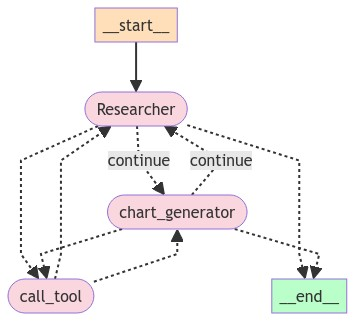

In [201]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph(xray=True).draw_mermaid_png()))
except:
    # This requires some extra dependencies and is optional
    pass

## Invoke

With the graph created, you can invoke it! Let's have it chart some stats for us.

In [202]:
events = graph.stream(
    {
        "messages": [
            HumanMessage(
                content="Fetch the UK's GDP over the past 5 years,"
                " then draw a line graph of it."
                " Once you code it up, finish."
            )
        ],
    },
    # Maximum number of steps to take in the graph
    {"recursion_limit": 150},
)
for s in events:
    print(s)
    print("----")

# Apply tools before generation
self.bound_tools [TavilySearchResults(max_results=4)]
prompts[0] System: You are a helpful AI assistant, collaborating with other assistants. Use the provided tools to progress towards answering the question. If you are unable to fully answer, that's OK, another assistant with different tools  will help where you left off. Execute what you can to make progress. If you or any of the other assistants have the final answer or deliverable, prefix your response with FINAL ANSWER so the team knows to stop. You have access to the following tools: tavily_search_results_json.
You should provide accurate data for the chart_generator to use.
Human: Fetch the UK's GDP over the past 5 years, then draw a line graph of it. Once you code it up, finish.
At _evaluate_tools:
tool_instances [TavilySearchResults(max_results=4)]
input_text System: You are a helpful AI assistant, collaborating with other assistants. Use the provided tools to progress towards answering the ques

In [217]:
#### Wrapper Version 0.2 Extended


logger = logging.getLogger(__name__)

class WatsonxLLM(BaseWatsonxLLM):
    """Extended IBM watsonx.ai large language models."""

    bound_tools: Optional[List[BaseTool]] = Field(default=None, exclude=True)

    def __init__(self, *args, tools: Optional[List[BaseTool]] = None, **kwargs):
        super().__init__(*args, **kwargs)
        self.bound_tools = tools or []

    def _generate(
        self,
        prompts: List[str],
        stop: Optional[List[str]] = None,
        run_manager: Optional[Any] = None,
        stream: Optional[bool] = None,
        **kwargs: Any,
        
    ) -> LLMResult:
        """Call the IBM watsonx.ai inference endpoint which then generate the response.
        Args:
            prompts: List of strings (prompts) to pass into the model.
            stop: Optional list of stop words to use when generating.
            run_manager: Optional callback manager.
            stream: Optional boolean flag to indicate streaming generation.
        Returns:
            The full LLMResult output.
        """
        params = self._get_chat_params(stop=stop)
        should_stream = stream if stream is not None else self.streaming
        if should_stream:
            if len(prompts) > 1:
                raise ValueError(
                    f"WatsonxLLM currently only supports single prompt, got {prompts}"
                )
            generation = GenerationChunk(text="")
            stream_iter = self._stream(
                prompts[0], stop=stop, run_manager=run_manager, **kwargs
            )
            for chunk in stream_iter:
                if generation is None:
                    generation = chunk
                else:
                    generation += chunk
            assert generation is not None
            if isinstance(generation.generation_info, dict):
                llm_output = generation.generation_info.pop("llm_output")
                return LLMResult(generations=[[generation]], llm_output=llm_output)
            return LLMResult(generations=[[generation]])
        else:
            # Apply tools before generation
            if self.bound_tools:
                print("# Apply tools before generation")
                print("self.bound_tools", self.bound_tools)
                print("prompts[0]", prompts[0])
                tool_output = self._evaluate_tools(self.bound_tools, prompts[0])
                print("Tool output: %s", tool_output)
                logger.info("Tool output: %s", tool_output)
                # You can include the tool output in the prompt or handle it as needed
                # For simplicity, we concatenate it to the prompt here
                # prompts[0] += "\n\n" + tool_output
                # Create a system prompt using the tool output
                system_prompt = (
                    f"You are an assistant with a tool. "
                    f"Provide a detailed answer to the user's query.\n\n"
                    f"User Query: {prompts[0]}\n\n"
                    f"Using the information below:\n"
                    f"Tool Results: {tool_output}\n\n"
                )
                # Set the new prompt with the system prompt first
                prompts[0] = system_prompt
            print("prompts", prompts)

            response = self.watsonx_model.generate(
                prompt=prompts, params=params, **kwargs
            )
            return self._create_llm_result(response)

    def _evaluate_tools(self, tool_instances: List[BaseTool], input_text: str) -> str:
        """Evaluate the provided tools and return their combined output.
        Args:
            tool_instances: List of tools to evaluate.
            input_text: Input text to provide to the tools.
        Returns:
            Combined output of the tool evaluations.
        """
        print("At _evaluate_tools:")
        
        print("tool_instances", tool_instances)
        print("input_text", input_text)
        combined_output = []
        for tool in tool_instances:
            try:
                result = tool.invoke(input_text)
                print("Tool Results in _evaluate_tools:", result)
                combined_output.append(result)
            except Exception as e:
                print(f"Error invoking tool {tool.name}: {str(e)}")
        return "\n\n".join(combined_output)

    @classmethod
    def bind_tools(
        cls,
        tools: Sequence[Union[Dict[str, Any], Type[BaseModel], Callable, BaseTool]],
        *,
        tool_choice: Optional[Union[Dict[str, str], Literal["any", "auto"], str]] = None,
        **kwargs: Any,
    ) -> 'WatsonxLLM':
        """Bind tool-like objects to this chat model.
        Assumes model is compatible with OpenAI tool-calling API.
        Args:
            tools: A list of tool definitions to bind to this chat model.
                Can be a dictionary, pydantic model, callable, or BaseTool. Pydantic
                models, callables, and BaseTools will be automatically converted to
                their schema dictionary representation.
            tool_choice: Which tool to require to call.
                Options are:
                    name of the tool (str): calls corresponding tool;
                    "auto" or None: automatically selects a tool (including no tool);
                    "any": force at least one tool to be called;
                    or a dict of the form:
                        {"type": "tool", "name": "tool_name"},
                        or {"type": "any"},
                        or {"type": "auto"};
            **kwargs: Any additional parameters to pass to the
                :class:`~langchain.runnable.Runnable` constructor.
        """
        formatted_tools = [convert_to_openai_tool(tool)["function"] for tool in tools]
        instance = cls(**kwargs)
        instance.bound_tools = tools
        if tool_choice is not None:
            kwargs["tool_choice"] = tool_choice
        return instance

    def _create_llm_result(self, response: List[dict]) -> LLMResult:
        """Create the LLMResult from the choices and prompts."""
        generations = []
        for res in response:
            results = res.get("results")
            if results:
                finish_reason = results[0].get("stop_reason")
                gen = Generation(
                    text=results[0].get("generated_text"),
                    generation_info={"finish_reason": finish_reason},
                )
                generations.append([gen])
        final_token_usage = self._extract_token_usage(response)
        llm_output = {
            "token_usage": final_token_usage,
            "model_id": self.model_id,
            "deployment_id": self.deployment_id,
        }
        return LLMResult(generations=generations, llm_output=llm_output)

In [42]:

logger = logging.getLogger(__name__)


class WatsonxLLM(BaseWatsonxLLM):
    """Extended IBM watsonx.ai large language models with tool integration."""
    bound_tools: Optional[List[BaseTool]] = Field(default=None, exclude=True)
    def __init__(self, *args, tools: Optional[List[BaseTool]] = None, **kwargs):
        super().__init__(*args, **kwargs)
        self.bound_tools = tools or []

    def bind_tools(
        self,
        tools: Sequence[Union[Dict[str, Any], Type[BaseModel], Callable, BaseTool]],
        *,
        tool_choice: Optional[
            Union[dict, str, Literal["auto", "none", "required", "any"], bool]
        ] = None,
        **kwargs: Any,
    ) -> Runnable[LanguageModelInput, BaseMessage]:
        """Bind tools to the WatsonxLLM.

        This method is adapted to use tools directly within the `_generate` function.
        It essentially stores the tools in the `bound_tools` attribute.

        Args:
            tools: A list of tool definitions to bind to this chat model.
                Can be a dictionary, pydantic model, callable, or BaseTool.
            tool_choice: (Not used in this implementation, but kept for compatibility.)
            **kwargs: Any additional parameters (not used in this implementation).
        """

        if kwargs:
            raise ValueError(f"Received unsupported arguments {kwargs}")
        self.bound_tools = tools
        return self  # Return self to allow for chaining with other Runnable methods

    def _generate(
        self,
        prompts: List[str],
        stop: Optional[List[str]] = None,
        run_manager: Optional[Any] = None,
        stream: Optional[bool] = None,
        **kwargs: Any,
    ) -> LLMResult:
        # ... (Rest of the _generate method remains unchanged)
        """Call the IBM watsonx.ai inference endpoint which then generate the response.
        Args:
            prompts: List of strings (prompts) to pass into the model.
            stop: Optional list of stop words to use when generating.
            run_manager: Optional callback manager.
            stream: Optional boolean flag to indicate streaming generation.
        Returns:
            The full LLMResult output.
        """
        params = self._get_chat_params(stop=stop)
        should_stream = stream if stream is not None else self.streaming
        if should_stream:
            if len(prompts) > 1:
                raise ValueError(
                    f"WatsonxLLM currently only supports single prompt, got {prompts}"
                )
            generation = GenerationChunk(text="")
            stream_iter = self._stream(
                prompts[0], stop=stop, run_manager=run_manager, **kwargs
            )
            for chunk in stream_iter:
                if generation is None:
                    generation = chunk
                else:
                    generation += chunk
            assert generation is not None
            if isinstance(generation.generation_info, dict):
                llm_output = generation.generation_info.pop("llm_output")
                return LLMResult(generations=[[generation]], llm_output=llm_output)
            return LLMResult(generations=[[generation]])
 
        else:  # Non-streaming case
            # Apply tools if available
            if self.bound_tools:
                tool_output = self._evaluate_tools(self.bound_tools, prompts[0])

                # Construct a system message based on tool results (or not)
                system_prompt = (
                    f"You are an assistant with access to the following tools: "
                    f"{', '.join([tool.name for tool in self.bound_tools])}. "
                    f"Use the tool results or your own knowledge to answer the user's query accurately.\n\n"
                    f"User Query: {prompts[0]}\n\n"
                    f"Tool Results: {tool_output if tool_output else 'None'}\n\n"
                )
                prompts[0] = system_prompt  # Update the prompt with tool info

            print("prompts", prompts)

            response = self.watsonx_model.generate(
                prompt=prompts, params=params, **kwargs
            )
            return self._create_llm_result(response)

    def _evaluate_tools(self, tool_instances: List[BaseTool], input_text: str) -> str:
        """Evaluate the provided tools and return their combined output.
        Args:
            tool_instances: List of tools to evaluate.
            input_text: Input text to provide to the tools.
        Returns:
            Combined output of the tool evaluations.
        """
        print("At _evaluate_tools:")
        
        print("tool_instances", tool_instances)
        print("input_text", input_text)
        combined_output = []
        for tool in tool_instances:
            try:
                result = tool.invoke(input_text)
                print("Tool Results in _evaluate_tools:", result)
                combined_output.append(result)
            except Exception as e:
                print(f"Error invoking tool {tool.name}: {str(e)}")
        return "\n\n".join(combined_output)

    @classmethod
    def bind_tools(
        cls,
        tools: Sequence[Union[Dict[str, Any], Type[BaseModel], Callable, BaseTool]],
        *,
        tool_choice: Optional[Union[Dict[str, str], Literal["any", "auto"], str]] = None,
        **kwargs: Any,
    ) -> 'WatsonxLLM':
        """Bind tool-like objects to this chat model.
        Assumes model is compatible with OpenAI tool-calling API.
        Args:
            tools: A list of tool definitions to bind to this chat model.
                Can be a dictionary, pydantic model, callable, or BaseTool. Pydantic
                models, callables, and BaseTools will be automatically converted to
                their schema dictionary representation.
            tool_choice: Which tool to require to call.
                Options are:
                    name of the tool (str): calls corresponding tool;
                    "auto" or None: automatically selects a tool (including no tool);
                    "any": force at least one tool to be called;
                    or a dict of the form:
                        {"type": "tool", "name": "tool_name"},
                        or {"type": "any"},
                        or {"type": "auto"};
            **kwargs: Any additional parameters to pass to the
                :class:`~langchain.runnable.Runnable` constructor.
        """
        formatted_tools = [convert_to_openai_tool(tool)["function"] for tool in tools]
        instance = cls(**kwargs)
        instance.bound_tools = tools
        if tool_choice is not None:
            kwargs["tool_choice"] = tool_choice
        return instance

    def _create_llm_result(self, response: List[dict]) -> LLMResult:
        """Create the LLMResult from the choices and prompts."""
        generations = []
        for res in response:
            results = res.get("results")
            if results:
                finish_reason = results[0].get("stop_reason")
                gen = Generation(
                    text=results[0].get("generated_text"),
                    generation_info={"finish_reason": finish_reason},
                )
                generations.append([gen])
        final_token_usage = self._extract_token_usage(response)
        llm_output = {
            "token_usage": final_token_usage,
            "model_id": self.model_id,
            "deployment_id": self.deployment_id,
        }
        return LLMResult(generations=generations, llm_output=llm_output)            # ... (Rest of the non-streaming generation logic)



In [43]:
def _set_env(var: str):
    load_dotenv()  # Load environment variables from .env file
    env_var = os.getenv(var)
    if not env_var:
        env_var = getpass.getpass(f"{var}: ")
        os.environ[var] = env_var
    return env_var


In [44]:
_set_env("TAVILY_API_KEY")
api_key = _set_env("WATSONX_API_KEY")
project_id = _set_env("PROJECT_ID")
url = "https://us-south.ml.cloud.ibm.com"

In [45]:
# Create an instance of WatsonxLLM
# WatsonxLLM initialization
parameters = {
    GenParams.DECODING_METHOD: DecodingMethods.SAMPLE.value,
    GenParams.MAX_NEW_TOKENS: 1000,
    GenParams.MIN_NEW_TOKENS: 50,
    GenParams.TEMPERATURE: 0.7,
    GenParams.TOP_K: 50,
    GenParams.TOP_P: 1
}
model_id = "ibm/granite-13b-instruct-v2"
watsonx_instance  = WatsonxLLM(
    model_id=model_id,
    url=url,
    apikey=api_key,
    project_id=project_id,
    params=parameters
)

In [46]:
def create_agent_simple(llm, tools, system_message: str , params_dict):
    """Create an agent."""
    parameters = params_dict["parameters"]
    model_id = params_dict["model_id"]
    url = params_dict["url"]
    api_key = params_dict["api_key"]
    project_id= params_dict["project_id"]
    prompt = ChatPromptTemplate.from_messages(
        [
            (
                "system",
                "You are a helpful AI assistant, collaborating with other assistants."
                " Use the provided tools to progress towards answering the question."
                " If you are unable to fully answer, that's OK, another assistant with different tools "
                " will help where you left off. Execute what you can to make progress."
                " If you or any of the other assistants have the final answer or deliverable,"
                " prefix your response with FINAL ANSWER so the team knows to stop."
                " You have access to the following tools: {tool_names}.\n{system_message}",
            ),
            MessagesPlaceholder(variable_name="messages"),
        ]
    )
    prompt = prompt.partial(system_message=system_message)
    prompt = prompt.partial(tool_names=", ".join([tool.name for tool in tools]))
    llm_with_tools = llm.bind_tools(tools=tools, model_id=model_id, url=url, apikey=api_key, project_id=project_id, params=parameters) 
    #return prompt | llm
    return prompt | llm_with_tools

In [47]:
# Research agent and node
params_dict = {
    "parameters": parameters,
    "model_id": model_id,
    "url": url,
    "api_key": api_key,
    "project_id": project_id
}

In [48]:
research_agent = create_agent_simple(
    watsonx_instance,
    [TavilySearchResults(max_results=4)],
    system_message="You should provide accurate data for the chart_generator to use.",
    params_dict=params_dict,
)
research_agent.invoke(["Who is Ruslan Magana"])


At _evaluate_tools:
tool_instances [TavilySearchResults(max_results=4)]
input_text System: You are a helpful AI assistant, collaborating with other assistants. Use the provided tools to progress towards answering the question. If you are unable to fully answer, that's OK, another assistant with different tools  will help where you left off. Execute what you can to make progress. If you or any of the other assistants have the final answer or deliverable, prefix your response with FINAL ANSWER so the team knows to stop. You have access to the following tools: tavily_search_results_json.
You should provide accurate data for the chart_generator to use.
Human: Who is Ruslan Magana
Tool Results in _evaluate_tools: HTTPError('400 Client Error: Bad Request for url: https://api.tavily.com/search')
prompts ["You are an assistant with access to the following tools: tavily_search_results_json. Use the tool results or your own knowledge to answer the user's query accurately.\n\nUser Query: System: 

"FINAL ANSWER404 Not Found\n\nI didn't find Ruslan Magana in the database.\n\nIf you have any other questions, please feel free to ask.\n\nGoodbye.400 Client Error: Bad Request for url: https://api.tavily.com/search\n\n"

In [ ]:
import logging
from typing import Any, Dict, List, Optional, Sequence, Type, Union, Callable, Literal
from pydantic import BaseModel, Field
from langchain_core.tools import BaseTool
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.runnables import Runnable
from langchain_ibm import WatsonxLLM as BaseWatsonxLLM
from langchain_core.utils.function_calling import convert_to_openai_tool
from langchain_core.outputs import LLMResult, Generation, GenerationChunk
from langchain_core.messages import BaseMessage
from langchain_core.language_models import LanguageModelInput
from dotenv import load_dotenv
from ibm_watsonx_ai.metanames import GenTextParamsMetaNames as GenParams
from ibm_watsonx_ai.foundation_models.utils.enums import DecodingMethods
import getpass
import os


In [226]:
logger = logging.getLogger(__name__)

class WatsonxLLM(BaseWatsonxLLM):
    """Extended IBM watsonx.ai large language models."""

    bound_tools: Optional[List[BaseTool]] = Field(default=None, exclude=True)

    def __init__(self, *args, tools: Optional[List[BaseTool]] = None, **kwargs):
        super().__init__(*args, **kwargs)
        self.bound_tools = tools or []

    def _generate(
        self,
        prompts: List[str],
        stop: Optional[List[str]] = None,
        run_manager: Optional[Any] = None,
        stream: Optional[bool] = None,
        **kwargs: Any,
        
    ) -> LLMResult:
        """Call the IBM watsonx.ai inference endpoint which then generate the response.
        Args:
            prompts: List of strings (prompts) to pass into the model.
            stop: Optional list of stop words to use when generating.
            run_manager: Optional callback manager.
            stream: Optional boolean flag to indicate streaming generation.
        Returns:
            The full LLMResult output.
        """
        params = self._get_chat_params(stop=stop)
        should_stream = stream if stream is not None else self.streaming
        if should_stream:
            if len(prompts) > 1:
                raise ValueError(
                    f"WatsonxLLM currently only supports single prompt, got {prompts}"
                )
            generation = GenerationChunk(text="")
            stream_iter = self._stream(
                prompts[0], stop=stop, run_manager=run_manager, **kwargs
            )
            for chunk in stream_iter:
                if generation is None:
                    generation = chunk
                else:
                    generation += chunk
            assert generation is not None
            if isinstance(generation.generation_info, dict):
                llm_output = generation.generation_info.pop("llm_output")
                return LLMResult(generations=[[generation]], llm_output=llm_output)
            return LLMResult(generations=[[generation]])
        else:
            # Apply tools before generation
            if self.bound_tools:
                tool_output = self._evaluate_tools(self.bound_tools, prompts[0])
                # Create a system prompt using the tool output
                system_prompt = (
                    f"You are an assistant with a tool. "
                    f"Provide a detailed answer to the user's query.\n\n"
                    f"User Query: {prompts[0]}\n\n"
                    f"Using the information below:\n"
                    f"Tool Results: {tool_output}\n\n"
                )
                # Set the new prompt with the system prompt first
                prompts[0] = system_prompt

            response = self.watsonx_model.generate(
                prompt=prompts, params=params, **kwargs
            )
            return self._create_llm_result(response)

    def _evaluate_tools(self, tool_instances: List[BaseTool], input_text: str) -> str:
        """Evaluate the provided tools and return their combined output.
        Args:
            tool_instances: List of tools to evaluate.
            input_text: Input text to provide to the tools.
        Returns:
            Combined output of the tool evaluations.
        """
        combined_output = []
        for tool in tool_instances:
            try:
                result = tool.invoke(input_text)
                combined_output.append(result)
            except Exception as e:
                print(f"Error invoking tool {tool.name}: {str(e)}")
        return "\n\n".join(combined_output)

    @classmethod
    def bind_tools(
        cls,
        tools: Sequence[Union[Dict[str, Any], Type[BaseModel], Callable, BaseTool]],
        *,
        tool_choice: Optional[
            Union[dict, str, Literal["auto", "none", "required", "any"], bool]
        ] = None,
        **kwargs: Any,
    ) -> Runnable[LanguageModelInput, BaseMessage]:
        """Bind tool-like objects to this chat model.

        Assumes model is compatible with OpenAI tool-calling API.

        Args:
            tools: A list of tool definitions to bind to this chat model.
                Can be  a dictionary, pydantic model, callable, or BaseTool. Pydantic
                models, callables, and BaseTools will be automatically converted to
                their schema dictionary representation.
            tool_choice: Which tool to require the model to call.
                Options are:
                name of the tool (str): calls corresponding tool;
                "auto": automatically selects a tool (including no tool);
                "none": does not call a tool;
                "any" or "required": force at least one tool to be called;
                True: forces tool call (requires `tools` be length 1);
                False: no effect;

                or a dict of the form:
                {"type": "function", "function": {"name": <<tool_name>>}}.
            **kwargs: Any additional parameters to pass to the
                :class:`~langchain.runnable.Runnable` constructor.
        """

        formatted_tools = [convert_to_openai_tool(tool) for tool in tools]
        if tool_choice:
            if isinstance(tool_choice, str):
                # tool_choice is a tool/function name
                if tool_choice not in ("auto", "none", "any", "required"):
                    tool_choice = {
                        "type": "function",
                        "function": {"name": tool_choice},
                    }
                # 'any' is not natively supported by OpenAI API.
                # We support 'any' since other models use this instead of 'required'.
                if tool_choice == "any":
                    tool_choice = "required"
            elif isinstance(tool_choice, bool):
                if len(tools) > 1:
                    raise ValueError(
                        "tool_choice=True can only be used when a single tool is "
                        f"passed in, received {len(tools)} tools."
                    )
                tool_choice = {
                    "type": "function",
                    "function": {"name": formatted_tools[0]["function"]["name"]},
                }
            elif isinstance(tool_choice, dict):
                tool_names = [
                    formatted_tool["function"]["name"]
                    for formatted_tool in formatted_tools
                ]
                if not any(
                    tool_name == tool_choice["function"]["name"]
                    for tool_name in tool_names
                ):
                    raise ValueError(
                        f"Tool choice {tool_choice} was specified, but the only "
                        f"provided tools were {tool_names}."
                    )
            else:
                raise ValueError(
                    f"Unrecognized tool_choice type. Expected str, bool or dict. "
                    f"Received: {tool_choice}"
                )
            kwargs["tool_choice"] = tool_choice
        return super().bind(tools=formatted_tools, **kwargs)

    def _create_llm_result(self, response: List[dict]) -> LLMResult:
        """Create the LLMResult from the choices and prompts."""
        generations = []
        for res in response:
            results = res.get("results")
            if results:
                finish_reason = results[0].get("stop_reason")
                gen = Generation(
                    text=results[0].get("generated_text"),
                    generation_info={"finish_reason": finish_reason},
                )
                generations.append([gen])
        final_token_usage = self._extract_token_usage(response)
        llm_output = {
            "token_usage": final_token_usage,
            "model_id": self.model_id,
            "deployment_id": self.deployment_id,
        }
        return LLMResult(generations=generations, llm_output=llm_output)



In [26]:
def _set_env(var: str):
    load_dotenv()  # Load environment variables from .env file
    env_var = os.getenv(var)
    if not env_var:
        env_var = getpass.getpass(f"{var}: ")
        os.environ[var] = env_var
    return env_var

_set_env("TAVILY_API_KEY")
api_key = _set_env("WATSONX_API_KEY")
project_id = _set_env("PROJECT_ID")
url = "https://us-south.ml.cloud.ibm.com"
   

In [27]:
# Create an instance of WatsonxLLM
# WatsonxLLM initialization
parameters = {
    GenParams.DECODING_METHOD: DecodingMethods.SAMPLE.value,
    GenParams.MAX_NEW_TOKENS: 1000,
    GenParams.MIN_NEW_TOKENS: 50,
    GenParams.TEMPERATURE: 0.7,
    GenParams.TOP_K: 50,
    GenParams.TOP_P: 1
}
model_id = "ibm/granite-13b-instruct-v2"
watsonx_instance  = WatsonxLLM(
    model_id=model_id,
    url=url,
    apikey=api_key,
    project_id=project_id,
    params=parameters
)

In [31]:
def create_agent_simple(
    llm: WatsonxLLM,
    tools: List[BaseTool],
    system_message: str,
    params_dict: Dict[str, Any],
):
    from langchain_core.prompts.chat import ChatPromptTemplate, MessagesPlaceholder
    prompt = ChatPromptTemplate.from_messages(
        [
            (
                "system",
                "You are a helpful AI assistant, collaborating with other assistants."
                " Use the provided tools to progress towards answering the question."
                " If you are unable to fully answer, that's OK, another assistant with different tools "
                " will help where you left off. Execute what you can to make progress."
                " If you or any of the other assistants have the final answer or deliverable,"
                " prefix your response with FINAL ANSWER so the team knows to stop."
                " You have access to the following tools: {tool_names}.\n{system_message}",
            ),
            MessagesPlaceholder(variable_name="messages"),
        ]
    )
    prompt = prompt.partial(system_message=system_message)
    prompt = prompt.partial(tool_names=", ".join([tool.name for tool in tools]))
    llm_with_tools = llm.bind_tools(tools=tools, **params_dict) 
    #return prompt | llm_with_tools
    return  llm_with_tools

In [32]:
# Research agent and node
params_dict = {
    "parameters": parameters,
    "model_id": "ibm/granite-13b-instruct-v2",
    "url": url,
    "api_key": api_key,
    "project_id": project_id
}


In [33]:

research_agent = create_agent_simple(
    watsonx_instance,
    [TavilySearchResults(max_results=4)],
    system_message="You should provide accurate data for the chart_generator to use.",
    params_dict=params_dict,
)
response = research_agent.invoke(["Who is Ruslan Magana"])
print(response)


ValidationError: 3 validation errors for WatsonxLLM
api_key
  extra fields not permitted (type=value_error.extra)
parameters
  extra fields not permitted (type=value_error.extra)
__root__
  Did not find apikey, please add an environment variable `WATSONX_APIKEY` which contains it, or pass `apikey` as a named parameter. (type=value_error)